# Electrophysiology introduction
This notebook introduces EEG data analysis by walking through computing an event-related potential (ERP). We import an example dataset containing an intracranial recording from a subject engaged in a visual target detection task, and compute the ERP in response to a target and a standard stimulus. Standard packages (numpy, scipy, and matplotlib) are introduced; basic printing and plotting are demonstrated; and an intuitive analysis requiring indexing and averaging is provided.

## Set-up

### Download data / code repository

In [1]:
# We begin by 'cloning' the GitHub repository for this workshop.
# This will download the data we will be analyzing in this notebook
!git clone https://github.com/mwprestonjr/ephys_workshop.git
%cd ephys_workshop

### Import packages

In [1]:
# Next we import the necessary packages for our analysis
import numpy as np # for general computing
import matplotlib.pyplot as plt # for plotting
import scipy.io as sio # for loading data


### Intro: target detection task

Target detection task design: The subject sequentially views a series of visual stimuli. 80% of the stimuli are 'standard stimuli' while 20% are 'target stimuli.' The subject must respond via a button press whenever the target stimuli is presented. This classic task has been used to investigate visual perception and attention.

![](./figures/target_detection_task.png)

### Load dataset

In [2]:
# Here we load the example dataset. This dataset contains an intracranial EEG
# recording (one channel) from a subject engaged in a target detection task.

# Use scipy to load dataset (dictionary containing experimental data)
data_in = sio.loadmat('data/ecog_data.mat', squeeze_me=True)

# Assign neural and behavioral data arrays to variables
eeg = data_in['data'] # Neural data from one channel (voltage v. time)
standard_stim = data_in['sta'] # Time index of standard stimuli events
target_stim = data_in['tar'] # Time index of target stimuli event 
response = data_in['resp'] # Time index of behavioral responses

# print dataset details
print(f"N EEG data points: {len(eeg)}")
print(f"N standard stimuli: {len(standard_stim)}")
print(f"N target stimuli: {len(target_stim)}")
print(f"N response times: {len(response)}")

N EEG data points: 1459920
N standard stimuli: 380
N target stimuli: 117
N response times: 117


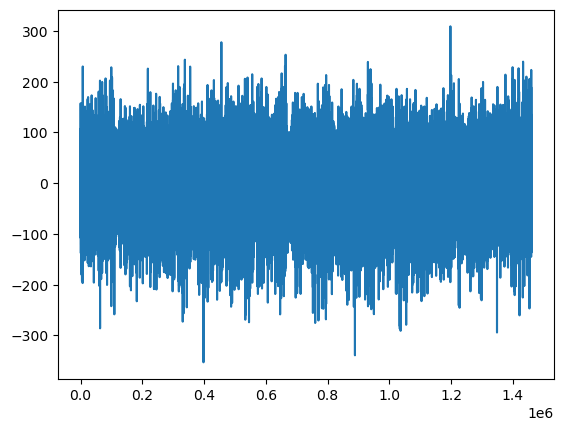

In [3]:
# Use matplotlib to visualize EEG data
plt.plot(eeg);

[  3.46000338   2.36433768   0.03803496 ...  11.55540848  -3.73713207
 -13.35820961]


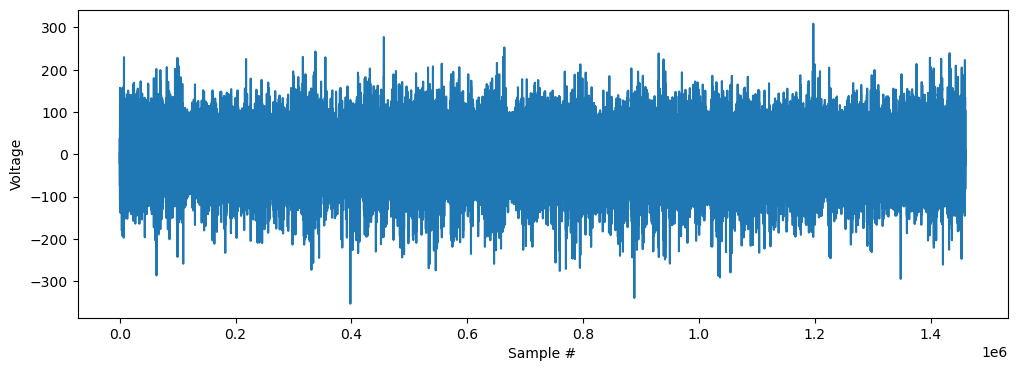

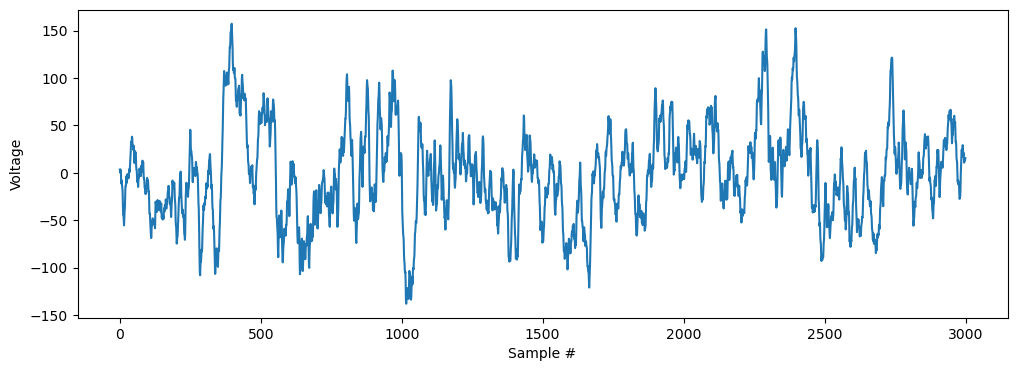

In [4]:
# Plot EEG time-series

# show data array
print(eeg)

# plot EEG time-series
plt.figure(figsize=[12,4])
plt.plot(eeg)
plt.xlabel('Sample #')
plt.ylabel('Voltage')
plt.show()

# plot EEG time-series snippet
plt.figure(figsize=[12,4])
plt.plot(eeg[:3000])
plt.xlabel('Sample #')
plt.ylabel('Voltage')
plt.show()

In [5]:
# Define time points for EEG data

# set sampling frequency: the data is sampled at 1000 samples per second (1000 Hz)
fs = 1000

# use numpy to define time vector
time_points = np.arange(len(eeg)) / fs # samples / (samples/second) = seconds
print(f"Shape of 'eeg': {eeg.shape}")
print(f"Shape of 'time_points': {time_points.shape}")
print(f"\nSignal duration: {time_points[-1]:.2f} seconds\n")
print(time_points)


Shape of 'eeg': (1459920,)
Shape of 'time_points': (1459920,)

Signal duration: 1459.92 seconds

[0.000000e+00 1.000000e-03 2.000000e-03 ... 1.459917e+03 1.459918e+03
 1.459919e+03]


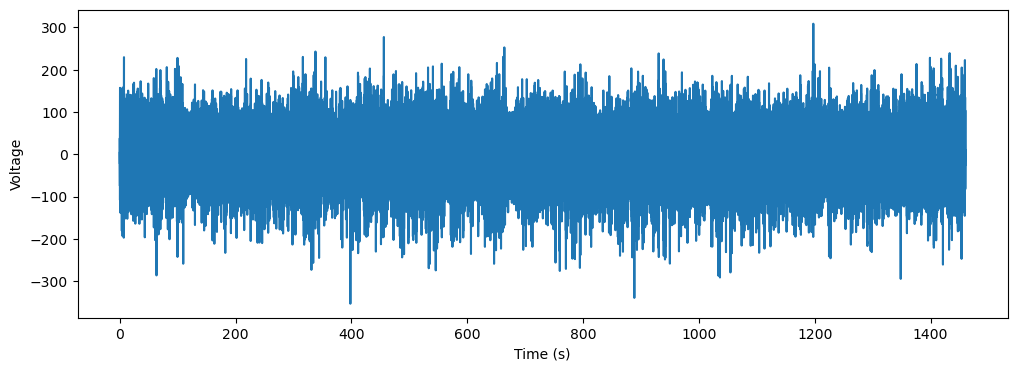

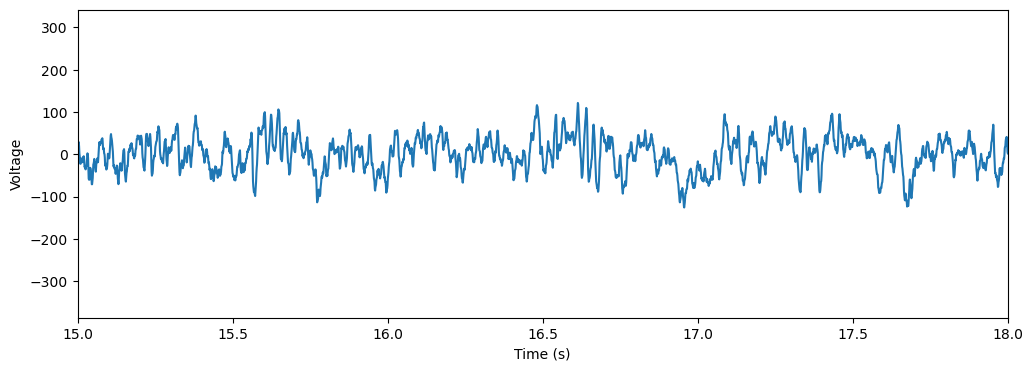

In [6]:
# Visualize EEG time-series

# plot fullEEG time-series
plt.figure(figsize=[12,4])
plt.plot(time_points, eeg)
plt.xlabel('Time (s)')
plt.ylabel('Voltage')
plt.show()

# plot EEG time-series snippet
plt.figure(figsize=[12,4])
plt.plot(time_points, eeg)
plt.xlim((15,18)) # limit x-range to show 3 second snippet of data only
plt.xlabel('Time (s)')
plt.ylabel('Voltage')
plt.show()

[369683 371912 383777 385253 385591 387681 389756 392031 395058 404634]


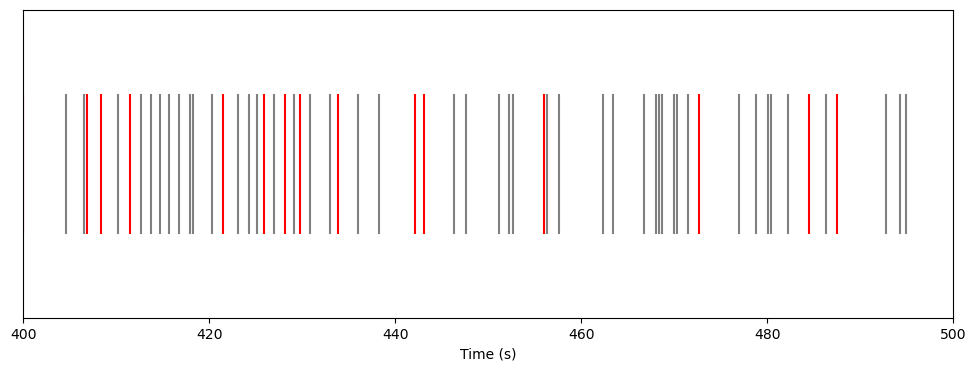

In [7]:
# visualize stimulus data

# show array
print(standard_stim[:10])

# plot stimulus times
plt.figure(figsize=[12,4])
plt.eventplot(standard_stim / fs, color='grey') # dividing by the sampling frequnecy (fs) converts the index to time in seconds
plt.eventplot(target_stim / fs, color='r')
plt.xlim((400, 500)) 
plt.xlabel('Time (s)')
plt.yticks([])
plt.show()

## Event-related potential (ERP) analysis
In this section we will compute and plot the ERP. We will compare the ERP in response to the target and standard stimuli. 

Time of first target stimuli: 370.021 s


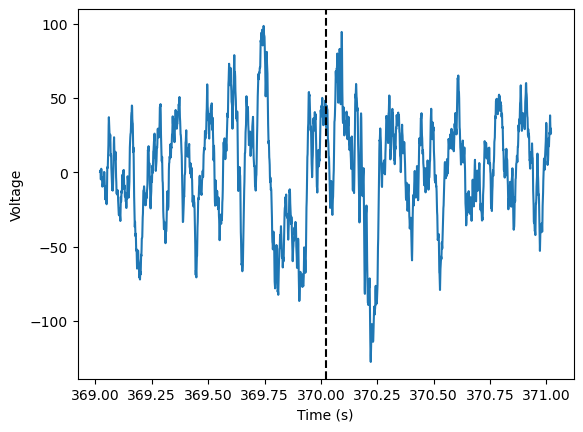

In [8]:
# plot response to target stimuli

# get data window (epoch) around stimulus time
print(f"Time of first target stimuli: {target_stim[0] / fs} s")
time_window = 1 * fs # take 1 second window before/after the stimulus time
idx_stim = target_stim[0] # get index of first stimuli
idx_start = idx_stim - time_window # index of epoch start
idx_end =  idx_stim + time_window # index of epoch end
erp_0 = eeg[idx_start : idx_end] # get ERP response to first target stimuli
erp_time = time_points[idx_start : idx_end] # get associated time points

# plot
plt.plot(erp_time, erp_0) # plot ERP
plt.axvline(idx_stim/fs, linestyle='--', color='k') # draw vertical line at stimulus time
plt.xlabel('Time (s)')
plt.ylabel('Voltage')
plt.show()

We see that the evoked response on a single trial is quite small and difficult to serarate from noise. Next, we will compute the ERP by averaging over many responses to the same stimulus. 

Shape of 'evoked_responses': (117, 2000)
Shape of 'erp': (2000,)


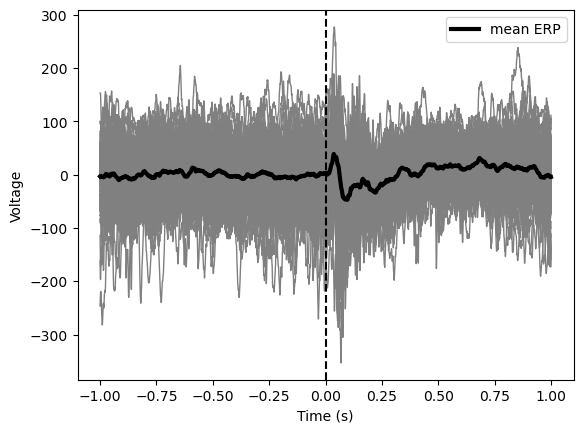

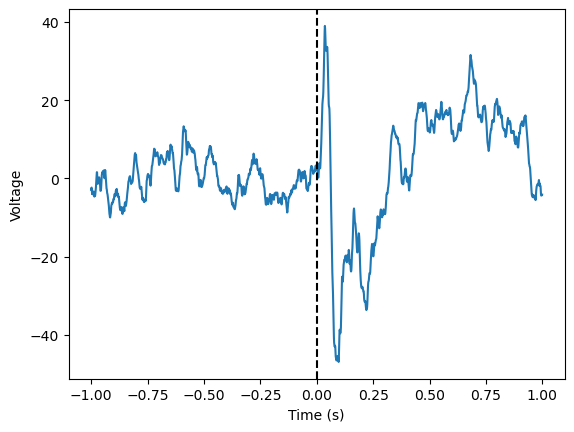

In [9]:
# compute average response to target stimulus

# initialize matrix to store response to each stimuli
n_samples = time_window * 2
evoked_responses = np.zeros([len(target_stim), n_samples]) 
print(f"Shape of 'evoked_responses': {evoked_responses.shape}")

# loop through each stimulus and store response
for ii, idx_stim in enumerate(target_stim):
    idx_stim = target_stim[ii] # get index of current stimuli
    idx_start = idx_stim - time_window
    idx_end =  idx_stim + time_window
    evoked_responses[ii] = eeg[idx_start : idx_end] # get ERP response to current target stimuli and store

# average response across trials
erp = np.mean(evoked_responses, axis=0)
print(f"Shape of 'erp': {erp.shape}")

# plot individual responses and mean ERP
erp_time = (np.arange(len(erp))/fs) - (time_window/fs) # define time vector
plt.plot(erp_time, evoked_responses.T, color='grey', linewidth=1) # plot ERP
plt.plot(erp_time, erp, color='k', linewidth=3, label='mean ERP') # plot ERP
plt.axvline(0, linestyle='--', color='k') # draw vertical line at stimulus time
plt.xlabel('Time (s)')
plt.ylabel('Voltage')
plt.legend()
plt.show()

# plot ERP 
plt.figure()
plt.plot(erp_time, erp) # plot ERP
plt.axvline(0, linestyle='--', color='k') # draw vertical line at stimulus time
plt.xlabel('Time (s)')
plt.ylabel('Voltage')
plt.show()

In [10]:
# define function to compute ERP

def compute_erp(data, stim_times, time_window):
    """
    Compute event-related potential (ERP) from neural data i.e. the average 
    response to a stimulus.
    
    Parameters
    ----------
    data : array
        1D array of neural data
    stim_times : array
        1D array of stimulus times
    time_window : int
        Window size (in samples) around each stimulus time
        
    Returns
    -------
    erp : array
        1D array of ERP
    """
    
    # preallocate array for ERP
    evoked_response = np.zeros((len(stim_times), time_window*2))
    
    # loop through each stimulus time
    for i, stim_time in enumerate(stim_times):
        
        # get data window (epoch) around stimulus time
        idx_start = stim_time - time_window
        idx_end =  stim_time + time_window
        evoked_response[i] = data[idx_start : idx_end]

    # average across stimuli
    erp = np.mean(evoked_response, axis=0)

    return erp

Shape of 'erp_target': (2000,)
Shape of 'erp_standard': (2000,)


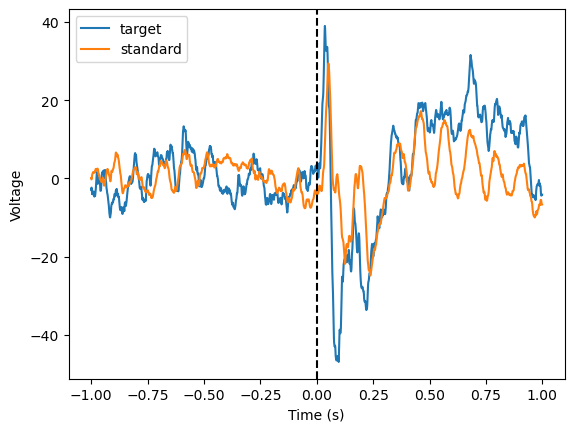

In [11]:
# compare ERP of target and response stimulus

# compute ERP for target and standard stimuli
erp_target = compute_erp(eeg, target_stim, time_window)
erp_standard = compute_erp(eeg, standard_stim, time_window)

# print shapes of ERP arrays
print(f"Shape of 'erp_target': {erp_target.shape}")
print(f"Shape of 'erp_standard': {erp_standard.shape}")

# plot ERPs
plt.figure()
plt.plot(erp_time, erp_target, label='target') # plot ERP for target stimulus
plt.plot(erp_time, erp_standard, label='standard') # plot ERP for standard stimulus
plt.axvline(0, linestyle='--', color='k') # draw vertical line at stimulus time
plt.xlabel('Time (s)')
plt.ylabel('Voltage')
plt.legend()
plt.show()

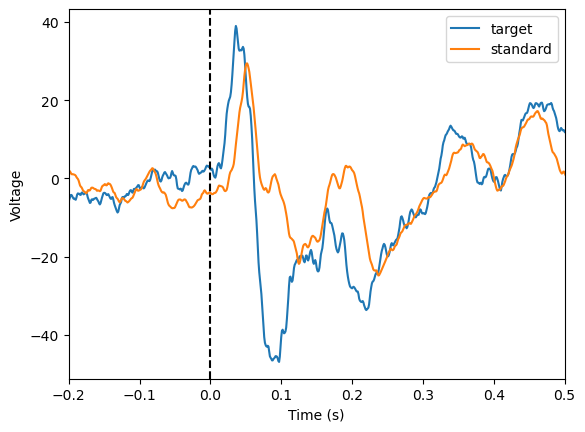

In [12]:
# plot ERPs - zoomed in on stimulus time
plt.figure()
plt.plot(erp_time, erp_target, label='target') # plot ERP for target stimulus
plt.plot(erp_time, erp_standard, label='standard') # plot ERP for standard stimulus
plt.axvline(0, linestyle='--', color='k') # draw vertical line at stimulus time
plt.xlabel('Time (s)')
plt.ylabel('Voltage')
plt.xlim((-0.2, 0.5)) # zoom in on stimulus time
plt.legend()
plt.show()